# NLP with GloVe embeddings and time

## Set-up

In [254]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import xavier_uniform_
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.chdir('..')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /cs/student/msc/ml/2020/sgeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Need to specify device so that code can easily run on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load training and dev data

In [5]:
train = pd.read_parquet('data/processed/train.parquet')
print(train.shape)

dev = pd.read_parquet('data/processed/dev.parquet')
print(dev.shape)

(749640, 13)
(92689, 13)


In [6]:
train.head()

,id_odsp,sort_order,time,text,event_type,event_team,opponent,is_goal,assist_method,fast_break,season,country,event_team_was_home
0,UFot0hit/,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Hamburg SV,Borussia Dortmund,0,Pass,0,2012,germany,0
1,UFot0hit/,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
2,UFot0hit/,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
3,UFot0hit/,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
4,UFot0hit/,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,Hamburg SV,Borussia Dortmund,0,None,0,2012,germany,0


In [7]:
# time_min_max_scalar = MinMaxScaler()
# time_min_max_scalar.fit(train[['time']])
# pickle.dump(time_min_max_scalar, open('models/time_min_max_scalar.pickle', 'wb'))

In [8]:
time_min_max_scalar = pickle.load(open('models/time_min_max_scalar.pickle', 'rb'))

In [9]:
def process_data_for_nlp(df):
    
    df = df.copy()
    
    # Sort by event order
    df.sort_values(['id_odsp', 'sort_order'], inplace=True)
    # Create target
    df['next_event_is_goal'] = df.groupby('id_odsp')['is_goal'].shift(-1)
    # Drop redundant columns
    df.drop(
        columns=['sort_order', 'event_type', 'event_team', 'opponent', 'assist_method', 'fast_break', 'season', 'country'], 
        inplace=True
    )
    # Drop entries with null target due to -1 shift
    df.dropna(subset=['next_event_is_goal'], axis=0, inplace=True)
    
    # Scale time
    df['time'] = time_min_max_scalar.transform(df[['time']])
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [10]:
train_p = process_data_for_nlp(train)
dev_p = process_data_for_nlp(dev)

train_p.shape, dev_p.shape

((742443, 6), (91789, 6))

In [11]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0


In [12]:
dev_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal
0,00nmICd9/,0.03,Foul by Juan Manuel FalcA³n (Metz).,0,1,0.0
1,00nmICd9/,0.03,TiemouA© Bakayoko (Monaco) wins a free kick in...,0,0,0.0
2,00nmICd9/,0.07,Foul by Anthony Martial (Monaco).,0,0,0.0
3,00nmICd9/,0.07,Sylvain Marchal (Metz) wins a free kick in the...,0,1,0.0
4,00nmICd9/,0.07,Foul by Cheick Doukoure (Metz).,0,1,0.0


## Tokenize text commentary

GloVe we are using is uncased so change all text to lower case:

In [13]:
def tokenize_text_commentary(df):
    df['text_lowercase'] = df['text'].str.lower()  # GloVe is lowercase
    df['text_split'] = df['text_lowercase'].apply(lambda x: word_tokenize(x))

In [14]:
%%time
tokenize_text_commentary(train_p)

CPU times: user 1min 37s, sys: 313 ms, total: 1min 37s
Wall time: 1min 37s


In [15]:
%%time
tokenize_text_commentary(dev_p)

CPU times: user 12.1 s, sys: 41.8 ms, total: 12.2 s
Wall time: 12.2 s


In [16]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ..."
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]"
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre..."
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]"
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou..."


In [17]:
dev_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split
0,00nmICd9/,0.03,Foul by Juan Manuel FalcA³n (Metz).,0,1,0.0,foul by juan manuel falca³n (metz).,"[foul, by, juan, manuel, falca³n, (, metz, ), .]"
1,00nmICd9/,0.03,TiemouA© Bakayoko (Monaco) wins a free kick in...,0,0,0.0,tiemoua© bakayoko (monaco) wins a free kick in...,"[tiemoua©, bakayoko, (, monaco, ), wins, a, fr..."
2,00nmICd9/,0.07,Foul by Anthony Martial (Monaco).,0,0,0.0,foul by anthony martial (monaco).,"[foul, by, anthony, martial, (, monaco, ), .]"
3,00nmICd9/,0.07,Sylvain Marchal (Metz) wins a free kick in the...,0,1,0.0,sylvain marchal (metz) wins a free kick in the...,"[sylvain, marchal, (, metz, ), wins, a, free, ..."
4,00nmICd9/,0.07,Foul by Cheick Doukoure (Metz).,0,1,0.0,foul by cheick doukoure (metz).,"[foul, by, cheick, doukoure, (, metz, ), .]"


In [18]:
# Combine all token lists together and find set to get vocab
vocab_set = set(
    itertools.chain.from_iterable(
        list(train_p['text_split'])
    )
)

In [19]:
len(vocab_set)

6468

In [20]:
# Create token to index dict
word_to_idx = dict(
    zip(
        vocab_set, 
        range(  # Start index from 1 as we reserve the 0 index for the padding vector
            1,
            len(vocab_set)+1
        )
    )
)

In [60]:
%%time
# For each sentence in training map tokens to corresponding index
train_p['token_sequence'] = [[word_to_idx[token] for token in commentary] for commentary in list(train_p['text_split'])]

CPU times: user 2.35 s, sys: 49 ms, total: 2.4 s
Wall time: 2.4 s


In [61]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split,token_sequence,token_sequence_1
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ...","[2210, 4002, 5093, 4494, 1414, 1937, 711, 3426...","[2210, 4002, 5093, 4494, 1414, 1937, 711, 3426..."
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]","[6156, 4936, 5146, 2985, 5093, 364, 1937, 5314]","[6156, 4936, 5146, 2985, 5093, 364, 1937, 5314..."
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre...","[1966, 2555, 5093, 364, 1937, 711, 3426, 6440,...","[1966, 2555, 5093, 364, 1937, 711, 3426, 6440,..."
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]","[6156, 4936, 3743, 3231, 5093, 4494, 1414, 193...","[6156, 4936, 3743, 3231, 5093, 4494, 1414, 193..."
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou...","[4453, 670, 5314, 3262, 2348, 5093, 364, 1937,...","[4453, 670, 5314, 3262, 2348, 5093, 364, 1937,..."


In [62]:
MAX_LENGTH = np.max([len(seq) for seq in train_p['token_sequence']])  # Max length of tokens for any sentence in the training data
MAX_LENGTH

50

In [72]:
def pad_sentence(sentence_seq, max_length=MAX_LENGTH):
    """
    Takes a list of numbers representing a sentence and appends zeros to the list until `max_length` is achieved.
    """
    if len(sentence_seq) < max_length:
        num_zeros_to_add = max_length - len(sentence_seq)
        zeros_list = list(np.zeros(num_zeros_to_add))
        zeros_list = [int(x) for x in zeros_list]  # Convert zeros to int
        
        sentence_seq = sentence_seq + zeros_list
        
    return sentence_seq

In [120]:
class CommentaryDataset(Dataset):

    def __init__(self, data, word_to_idx, max_length=MAX_LENGTH):
        """
        """
        data = data.copy()
        
        # Initial pre-processing
        data = process_data_for_nlp(data)
        
        # Tokenise text commentary
        tokenize_text_commentary(data)
        
        # Look up each token in word_to_index (from training) and get index value or drop if not in dictionary
        data['token_sequence'] = [
            [word_to_idx.get(token) for token in commentary if word_to_idx.get(token) != None] for commentary in list(data['text_split'])
        ]
        
        # Trim to length
        data['token_sequence'] = [token_sequence[:max_length] for token_sequence in list(data['token_sequence'])]
        
        # Pad sentences
        data['token_sequence'] = [pad_sentence(token_sequence) for token_sequence in data['token_sequence']]
        
        # Lagged features
        for i in range(1,5):
            data[f'token_sequence_minus_{i}'] = data.groupby('id_odsp')['token_sequence'].shift(i)
            data[f'time_minus_{i}'] = data.groupby('id_odsp')['time'].shift(i)
            data[f'is_goal_minus_{i}'] = data.groupby('id_odsp')['is_goal'].shift(i)
            
        data.dropna(axis=0, how='any', inplace=True)  # Drop rows with empty features caused by lag
        
        token_sequence = ['token_sequence'] + [f'token_sequence_minus_{i}' for i in range(1, 5)]
        token_sequence.reverse()  # Order from furthest away to most recent
        self.token_sequence = np.array(data[token_sequence].values.tolist())  # Create 3D matrix of token sequences of shape (batch size, timesteps, tokens)
        
        time = ['time'] + [f'time_minus_{i}' for i in range(1, 5)]
        time.reverse()
        self.time = data[time].values
        
        goal = ['is_goal'] + [f'is_goal_minus_{i}' for i in range(1, 5)]
        goal.reverse()
        self.goal = data[goal].values
        
        self.event_team_was_home = data['event_team_was_home'].values
        
        self.y = data['next_event_is_goal'].values

    def __len__(self):
        return self.token_sequence.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.token_sequence[idx, :, :], self.time[idx, :], self.goal[idx, :], self.event_team_was_home[idx], self.y[idx]

In [121]:
%%time
train_comm = CommentaryDataset(train, word_to_idx)

CPU times: user 2min 6s, sys: 1.39 s, total: 2min 7s
Wall time: 2min 7s


In [122]:
%%time
dev_comm = CommentaryDataset(dev, word_to_idx)

CPU times: user 14.9 s, sys: 145 ms, total: 15 s
Wall time: 15.1 s


In [98]:
# # Create training array where each row has the token indices for the word in that sentence
# X_train = np.array(
#     list(train_p['token_sequence'])
# )

# X_train.shape

## Load pre-trained GloVe embeddings

In [81]:
%%time
word_to_vector = {}
with open('data/external/glove.6B.100d.txt', "r") as f:
    # Each line starts with the word/character followed by the 100d vector representation
    for line in f:
        
        # Split by whitespace:
        components = line.split()
        
        word = components[0]
        vector_values = components[1:]
        
        vector_array = np.array(vector_values, dtype=np.float64)  # Convert vector to numpy array
        
        # Add to dictionary
        word_to_vector[word] = vector_array

CPU times: user 6.82 s, sys: 212 ms, total: 7.03 s
Wall time: 7.04 s


In [82]:
len(word_to_vector.keys())

400000

In [83]:
word_to_vector['foul']

array([ 8.8509e-01, -8.0413e-01,  7.3326e-01, -1.1997e+00, -4.4433e-01,
        9.9010e-01, -1.1211e-01, -7.0893e-01, -1.4639e-01, -1.9667e-01,
       -1.4831e-01, -1.0859e-01, -3.9821e-01, -4.9383e-01,  1.0474e+00,
        6.4321e-01, -6.4378e-01, -2.7974e-01, -4.2865e-01,  5.5361e-02,
        2.1271e-01,  6.2063e-01,  1.1255e-01, -9.9549e-02,  5.2189e-01,
       -2.9921e-01, -6.3453e-01,  5.5675e-01,  1.0460e-01, -1.0456e-01,
        3.0833e-02, -1.0498e-03,  5.6656e-01, -1.1333e-01, -5.8664e-02,
       -5.9103e-01, -2.2791e-01,  3.2208e-01,  6.9484e-02,  3.6374e-01,
       -3.4399e-01,  3.3388e-02,  1.2079e-01, -6.0931e-01, -3.2988e-01,
        5.1176e-02, -3.5307e-01, -4.5887e-02, -2.0085e-01, -6.6991e-01,
        4.3831e-01,  3.8817e-01, -9.4224e-01,  5.2481e-01, -7.7710e-02,
       -1.3177e+00, -1.2479e-01,  3.3277e-01,  1.1003e+00,  4.8362e-01,
       -3.4234e-01,  1.5704e-01, -6.7879e-01,  4.4289e-01, -1.7270e-01,
       -5.3625e-01,  1.0005e+00, -9.6411e-01, -1.2487e+00, -1.94

## Create embedding matrix

In [84]:
GLOVE_DIMENSION = 100

In [85]:
# Create empty matrix for embedding matrix
embedding_matrix = np.zeros(
    (
        len(vocab_set) + 1,  # Additional 1 for zero vector for padding
        GLOVE_DIMENSION
    )
)
embedding_matrix.shape

(6469, 100)

In [86]:
len(word_to_idx.keys())

6468

In [87]:
for word, idx in word_to_idx.items():
    try:
        embedding_matrix[idx, :] = word_to_vector[word]
    except KeyError:  # Word in training set not in GloVe
        embedding_matrix[idx, :] = np.zeros(GLOVE_DIMENSION)  # We replace unknown words with zeros

In [88]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.54137 , -0.28764 , -0.73927 , ..., -0.18333 , -0.36724 ,
        -0.93653 ],
       [-0.71766 ,  0.80871 ,  0.31868 , ..., -1.0023  ,  0.8588  ,
         0.28583 ],
       ...,
       [-0.14006 , -0.23714 , -0.17842 , ..., -0.47708 ,  0.16928 ,
        -0.26209 ],
       [ 0.048094, -0.48372 , -0.1568  , ...,  0.65844 , -0.55271 ,
         0.10198 ],
       [ 0.043713, -0.31769 , -0.44245 , ...,  0.17994 , -0.78125 ,
         0.20462 ]])

In [89]:
np.sum(embedding_matrix.sum(axis=1) == 0)  # Number of words in vocab but not in GloVe

1885

In [130]:
# Convert to tensor for PyTorch
embedding_tensor = torch.from_numpy(embedding_matrix)
embedding_tensor = embedding_tensor.to(device)

## Train model

In [96]:
train_comm.token_sequence[:,1,:].shape

(713655, 50)

In [101]:
train_comm.event_team_was_home.shape

(713655,)

In [102]:
train_comm.goal.shape

(713655, 5)

In [103]:
train_comm.time.shape

(713655, 5)

In [105]:
train_comm.y.shape

(713655,)

In [117]:
np.concatenate((train_comm.event_team_was_home.reshape(-1,1), train_comm.event_team_was_home.reshape(-1,1)), axis=1).shape

(713655, 2)

In [142]:
train_comm.token_sequence[:,0,:][0].dtype

dtype('int64')

In [129]:
embedding_tensor

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5414, -0.2876, -0.7393,  ..., -0.1833, -0.3672, -0.9365],
        [-0.7177,  0.8087,  0.3187,  ..., -1.0023,  0.8588,  0.2858],
        ...,
        [-0.1401, -0.2371, -0.1784,  ..., -0.4771,  0.1693, -0.2621],
        [ 0.0481, -0.4837, -0.1568,  ...,  0.6584, -0.5527,  0.1020],
        [ 0.0437, -0.3177, -0.4425,  ...,  0.1799, -0.7812,  0.2046]],
       device='cuda:0', dtype=torch.float64)

In [228]:
class NextEventIsGoal(nn.Module):

    def __init__(self):
        super(NextEventIsGoal, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_tensor, freeze=False)
        # LSTM
        self.lstm_sentences = nn.LSTM(input_size=GLOVE_DIMENSION, hidden_size=125, batch_first=True)
        self.lstm_features = nn.LSTM(input_size=125+2, hidden_size=300, batch_first=True)
        
        # MLP
        self.fc_1 = nn.Linear(in_features=300+1, out_features=125)
        self.fc_2 = nn.Linear(in_features=125, out_features=1)

        xavier_uniform_(self.fc_1.weight)  # in-place
        xavier_uniform_(self.fc_2.weight)  # in-place        
        
        self.dropout = nn.Dropout(p=0)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, token_sequence, event_team_was_home, goal, time):
        
        x_0 = self.embedding(token_sequence[:,0,:])
        x_0 = x_0.float()
        all_h_t0, _ = self.lstm_sentences(x_0)
        h_T0 = all_h_t0[:, -1, :]  # Final cell outputs
        
        x_1 = self.embedding(token_sequence[:,1,:])
        x_1 = x_1.float()
        all_h_t1, _ = self.lstm_sentences(x_1)
        h_T1 = all_h_t1[:, -1, :]  # Final cell outputs
        
        x_2 = self.embedding(token_sequence[:,2,:])
        x_2 = x_2.float()
        all_h_t2, _ = self.lstm_sentences(x_2)
        h_T2 = all_h_t2[:, -1, :]  # Final cell outputs
        
        x_3 = self.embedding(token_sequence[:,3,:])
        x_3 = x_3.float()
        all_h_t3, _ = self.lstm_sentences(x_3)
        h_T3 = all_h_t3[:, -1, :]  # Final cell outputs
        
        x_4 = self.embedding(token_sequence[:,4,:])
        x_4 = x_4.float()
        all_h_t4, _ = self.lstm_sentences(x_4)
        h_T4 = all_h_t4[:, -1, :]  # Final cell outputs
        
        sentence_representation_over_time = torch.stack(
            (h_T0, h_T1, h_T2, h_T3, h_T4),
            dim=1  # Put timesteps on axis 1
        )
        
        goal_and_mins_over_time = torch.stack(
            (goal, time),
            dim=2  # Feautures as 3rd dimension
        )
        
        x = torch.cat(
            (sentence_representation_over_time, goal_and_mins_over_time), 
            dim=2
        )
        
        x = x.float()
        
        all_h_t, _ = self.lstm_features(x)
        h_T = all_h_t[:, -1, :]  # Final cell outputs
        
        x = torch.cat((h_T, event_team_was_home.reshape(-1, 1)), dim=1)
        
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)

        x = self.sigmoid(x)
        
        return x

In [229]:
model = NextEventIsGoal()
model.to(device)

NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm_sentences): LSTM(100, 125, batch_first=True)
  (lstm_features): LSTM(127, 300, batch_first=True)
  (fc_1): Linear(in_features=301, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [230]:
model.named_parameters

<bound method Module.named_parameters of NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm_sentences): LSTM(100, 125, batch_first=True)
  (lstm_features): LSTM(127, 300, batch_first=True)
  (fc_1): Linear(in_features=301, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

In [231]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
sum(p.numel() for p in model.parameters() if p.requires_grad)

1313076

In [232]:
criterion = nn.BCELoss()
optimiser = optim.Adam(params=model.parameters(), lr=0.0001)

Use subset of training data otherwise takes forever...

In [233]:
len(train_comm)

713655

In [240]:
num_subset_examples = 1000

train_ncd_subset = torch.utils.data.Subset(
    train_comm, 
    indices=np.random.choice(
        range(len(train_comm)), 
        num_subset_examples
    )
)

In [260]:
training_losses = []
dev_losses = [0]

In [261]:
from tqdm import tqdm

In [262]:
1000/16

62.5

In [269]:
%%time
for epoch in tqdm(range(10), position=0):
    for data in tqdm(DataLoader(train_ncd_subset, batch_size=8), position=1):
        
        token_sequence, time, goal, event_team_was_home, y = data
        token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)

        optimiser.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = model(token_sequence, event_team_was_home, goal, time)
        loss = criterion(y_pred, y.float())

        loss.backward()
        optimiser.step()
    
    # Training loss
    training_loss_total = 0
    for data in DataLoader(train_ncd_subset, batch_size=2048, shuffle=True):
        token_sequence, time, goal, event_team_was_home, y = data
        token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)
        
        y_pred = model(token_sequence, event_team_was_home, goal, time)
        
        batch_loss_sum = float(
            nn.BCELoss(reduction='sum')(y_pred, y.float())
        )
        training_loss_total += batch_loss_sum
    
    loss = training_loss_total / len(train_ncd_subset)
    training_losses.append(loss)
        
    # Dev loss
#     dev_loss_total = 0
#     for data in DataLoader(commentary_dev, batch_size=2048):
#         X_dev, y_dev = data
#         X_dev, y_dev = X_dev.to(device), y_dev.to(device)
        
#         y_pred = model(X_dev)
        
#         batch_loss_sum = float(
#             nn.BCELoss(reduction='sum')(y_pred, y_dev.float())
#         )
#         dev_loss_total += batch_loss_sum
        
#     loss = dev_loss_total / len(commentary_dev)
#     dev_losses.append(loss)
    
    print(f'Epoch: {epoch+1}, train_loss: {training_losses[-1]}, dev_loss: {dev_losses[-1]}')

  0%|          | 0/10 [00:04<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 120.00 MiB (GPU 0; 1.93 GiB total capacity; 1.02 GiB already allocated; 28.75 MiB free; 1.21 GiB reserved in total by PyTorch)

In [246]:
plt.figure(figsize=(8, 6))
pd.DataFrame({'train': training_losses, 'dev': dev_losses}).plot()
plt.show()

ValueError: arrays must all be same length

<Figure size 576x432 with 0 Axes>

## Training ROCAUC

In [68]:
y_train_list = []
y_pred_list = []

for data in DataLoader(commentary_train, batch_size=2048):
    X_train, y_train = data
    X_train, y_train = X_train.to(device), y_train.to(device)

    y_pred = model(X_train)
    
    y_train_list.append(y_train.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

In [69]:
y_train = np.concatenate(y_train_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [70]:
roc_auc_score(y_train, y_pred)

0.6724677853670019

## Dev ROCAUC

In [72]:
y_dev_list = []
y_pred_list = []

for data in DataLoader(commentary_dev, batch_size=256):
    X_dev, y_dev = data
    X_dev, y_dev = X_dev.to(device), y_dev.to(device)

    y_pred = model(X_dev)
    
    y_dev_list.append(y_dev.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

In [73]:
y_dev = np.concatenate(y_dev_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [74]:
roc_auc_score(y_dev, y_pred)

0.6503720392454373

# Add minutes and home team features

## Create custom Dataset class

In [207]:
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((742443, 50), (742443,), (91789, 50), (91789,))

In [208]:
train_p.head()

,id_odsp,time,text,event_team_was_home,next_event_is_goal,text_lowercase,text_split,token_sequence
0,004f4ING/,0.010101,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ...","[5455, 3019, 2529, 4858, 52, 3767, 4304, 3725,..."
1,004f4ING/,0.010101,Foul by Maya Yoshida (Southampton).,1,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]","[5791, 4039, 1961, 3289, 2529, 3338, 3767, 560..."
2,004f4ING/,0.050505,Dusan Tadic (Southampton) wins a free kick on ...,1,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre...","[5731, 5113, 2529, 3338, 3767, 4304, 3725, 324..."
3,004f4ING/,0.050505,Foul by Neil Taylor (Swansea City).,0,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]","[5791, 4039, 2798, 1976, 2529, 4858, 52, 3767,..."
4,004f4ING/,0.060606,Attempt saved. James Ward-Prowse (Southampton)...,1,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou...","[5043, 1098, 5600, 165, 5305, 2529, 3338, 3767..."


In [209]:
from sklearn.preprocessing import MinMaxScaler

In [210]:
min_max_scalar = MinMaxScaler()

In [211]:
train_p['time'] = min_max_scalar.fit_transform(train_p[['time']]).flatten()

In [212]:
dev_p['time'] = min_max_scalar.transform(dev_p[['time']]).flatten()

In [213]:
time_home_train = train_p.copy()[['time', 'event_team_was_home']].values
time_home_dev = dev_p.copy()[['time', 'event_team_was_home']].values

In [214]:
class CommentaryDatasetPlus(Dataset):

    def __init__(self, X, y, time_home_features):
        """
        """
        self.X = X
        self.y = y.reshape(-1, 1)
        self.time_home_features = time_home_features

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.X[idx, :], self.time_home_features[idx, :], self.y[idx, :]

In [215]:
commentary_train_plus = CommentaryDatasetPlus(X_train, y_train, time_home_train)
commentary_dev_plus = CommentaryDatasetPlus(X_dev, y_dev, time_home_dev)

In [216]:
class NextEventIsGoalPlus(nn.Module):

    def __init__(self):
        super(NextEventIsGoalPlus, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_tensor, freeze=False)
        # LSTM
        self.lstm = nn.LSTM(input_size=GLOVE_DIMENSION, hidden_size=125, batch_first=True)
        # MLP
        self.fc_1 = nn.Linear(in_features=125+2, out_features=125)  # +2 for time and home features
        self.fc_2 = nn.Linear(in_features=125, out_features=1)

        xavier_uniform_(self.fc_1.weight)  # in-place
        xavier_uniform_(self.fc_2.weight)  # in-place        
        
        self.dropout = nn.Dropout(p=0)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_time_home):
        x = self.embedding(x)
        
        x = x.float()
        x_time_home = x_time_home.float()
        
        all_h_t, _ = self.lstm(x)
        
        h_T = all_h_t[:, -1, :]  # Final cell outputs
        
        x = torch.cat((h_T, x_time_home), dim=1)
        
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)

        x = self.sigmoid(x)
        
        return x

In [217]:
model = NextEventIsGoalPlus()
model.to(device)

NextEventIsGoalPlus(
  (embedding): Embedding(6469, 100)
  (lstm): LSTM(100, 125, batch_first=True)
  (fc_1): Linear(in_features=127, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [218]:
model.named_parameters

<bound method Module.named_parameters of NextEventIsGoalPlus(
  (embedding): Embedding(6469, 100)
  (lstm): LSTM(100, 125, batch_first=True)
  (fc_1): Linear(in_features=127, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

In [219]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
sum(p.numel() for p in model.parameters() if p.requires_grad)

776526

In [220]:
criterion = nn.BCELoss()
optimiser = optim.Adam(params=model.parameters(), lr=0.0001)

Use subset of training data otherwise takes forever...

In [221]:
len(commentary_train_plus)

742443

In [222]:
# num_subset_examples = 50000

# train_ncd_subset = torch.utils.data.Subset(
#     commentary_train_plus, 
#     indices=np.random.choice(
#         range(len(commentary_train_plus)), 
#         num_subset_examples
#     )
# )

In [223]:
training_losses = []
dev_losses = []

In [225]:
%%time
# training_losses = []
# dev_losses = []

for epoch in range(5):
    for data in DataLoader(commentary_train_plus, batch_size=256):
        
        X, X_time_home, y = data
        X, X_time_home, y = X.to(device), X_time_home.to(device), y.to(device)

        optimiser.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = model(X, X_time_home)
        loss = criterion(y_pred, y.float())

        loss.backward()
        optimiser.step()
    
    # Training loss
    training_loss_total = 0
    for data in DataLoader(commentary_train_plus, batch_size=256, shuffle=True):
        X_train, X_time_home_train, y_train = data
        X_train, X_time_home_train, y_train = X_train.to(device), X_time_home_train.to(device), y_train.to(device)
        
        y_pred = model(X_train, X_time_home_train)
        
        batch_loss_sum = float(
            nn.BCELoss(reduction='sum')(y_pred, y_train.float())
        )
        training_loss_total += batch_loss_sum
    
    loss = training_loss_total / len(commentary_train_plus)
    training_losses.append(loss)
        
    # Dev loss
    dev_loss_total = 0
    for data in DataLoader(commentary_dev_plus, batch_size=256):
        X_dev, X_time_home_dev, y_dev = data
        X_dev, X_time_home_dev, y_dev = X_dev.to(device), X_time_home_dev.to(device), y_dev.to(device)
        
        y_pred = model(X_dev, X_time_home_dev)
        
        batch_loss_sum = float(
            nn.BCELoss(reduction='sum')(y_pred, y_dev.float())
        )
        dev_loss_total += batch_loss_sum
        
    loss = dev_loss_total / len(commentary_dev_plus)
    dev_losses.append(loss)
    
    print(f'Epoch: {epoch+1}, train_loss: {training_losses[-1]}, dev_loss: {dev_losses[-1]}')

Epoch: 1, train_loss: 0.11283278551108274, dev_loss: 0.1192946303160784
Epoch: 2, train_loss: 0.11269831692717594, dev_loss: 0.11941011535204334
Epoch: 3, train_loss: 0.11257904717308226, dev_loss: 0.11954914900267681
Epoch: 4, train_loss: 0.11249491840436912, dev_loss: 0.1198080030532985
Epoch: 5, train_loss: 0.1124026030508974, dev_loss: 0.12012534370169266
CPU times: user 13min 20s, sys: 4min 7s, total: 17min 28s
Wall time: 17min 28s


<Figure size 576x432 with 0 Axes>

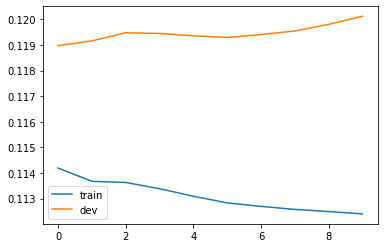

In [226]:
plt.figure(figsize=(8, 6))
pd.DataFrame({'train': training_losses, 'dev': dev_losses}).plot()
plt.show()

## Training ROCAUC

In [227]:
y_train_list = []
y_pred_list = []

for data in DataLoader(commentary_train_plus, batch_size=256):
    X_train, X_time_home_train, y_train = data
    X_train, X_time_home_train, y_train = X_train.to(device), X_time_home_train.to(device), y_train.to(device)

    y_pred = model(X_train, X_time_home_train)
    
    y_train_list.append(y_train.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

In [228]:
y_train = np.concatenate(y_train_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [229]:
roc_auc_score(y_train, y_pred)

0.7053438363124321

## Dev ROCAUC

In [230]:
y_dev_list = []
y_pred_list = []

for data in DataLoader(commentary_dev_plus, batch_size=256):
    X_dev, X_time_home_dev, y_dev = data
    X_dev, X_time_home_dev, y_dev = X_dev.to(device), X_time_home_dev.to(device), y_dev.to(device)

    y_pred = model(X_dev, X_time_home_dev)
    
    y_dev_list.append(y_dev.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

In [231]:
y_dev = np.concatenate(y_dev_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [232]:
roc_auc_score(y_dev, y_pred)

0.626376404819081

- Overfitting more of an issue when minutes and home team features are added
- Better training ROCAUC
- Worse dev ROCAUC

## References

https://nlp.stanford.edu/projects/glove/